In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import datetime

In [8]:
import datetime

# taking the input from the user 
def taking_user_input():
    stock_name = input("Enter the stock name (e.g., 'AAPL' for Apple, 'GOOGL' for Alphabet Inc):").strip()

    while True:
        start_date = input("Enter the starting date (YYYY-MM-DD): ").strip()
        try:
            start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
            break
        except ValueError:
            print("Invalid date format.")

    while True:
        end_date = input("Enter the ending date (YYYY-MM-DD): ").strip()
        try:
            end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
            if end_date > start_date:
                break
            else:
                print("End date must be after the starting date.")
        except ValueError:
            print("Invalid date format.")

    timeframes = ["daily", "weekly", "monthly"]
    print(f"Timeframes that are available: {', '.join(timeframes)}")

    while True:
        timeframe = input("Enter the timeframe: ").strip().lower()
        if timeframe in timeframes:
            break
        else:
            print("Invalid timeframe. Please choose from daily, weekly, or monthly.")

    return stock_name, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), timeframe



In [9]:
stockn ,startd ,endd,tf = taking_user_input()



Enter the stock name (e.g., 'AAPL' for Apple, 'GOOGL' for Alphabet Inc): AAPL
Enter the starting date (YYYY-MM-DD):  2024-01-01
Enter the ending date (YYYY-MM-DD):  2025-03-01


Timeframes that are available: daily, weekly, monthly


Enter the timeframe:  daily


In [10]:
def download_historical_data( stockn , startd , endd , tf ):
   timeframe_key = { "daily": "1d", "monthly": "1mo" ,"weekly": "1wk"}
   yf_interval = timeframe_key.get(tf)
   dataframe = yf.download(tickers=stockn , start=startd , end = endd , interval = yf_interval)
   return dataframe

In [11]:
data_frame = download_historical_data(stockn,startd,endd, tf)
data_frame.head()

C:\Users\ronak\AppData\Local\Temp\ipykernel_51840\1115519606.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataframe = yf.download(tickers=stockn , start=startd , end = endd , interval = yf_interval)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.290421,187.070068,182.553143,185.789438,82488700
2024-01-03,182.910507,184.528662,182.096461,182.880727,58414500
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500


In [12]:
# plot all closing prices

def plot_closing_price(data_frame, stockn):
    if 'Close' not in data_frame.columns:
        print(f"No 'Close' column found in the data for {stockn}.")
        return
    
    plt.figure(figsize=(10, 6))
    plt.plot(data_frame.index, data_frame['Close'], label=f'{stockn} Closing Price', color='green')
    
    # Plot the last value as a dot
    last_value = data_frame['Close'].iloc[-1]
    plt.plot(data_frame.index[-1], last_value, 'ro')  # 'ro' means red dot
    
    plt.title(f'{stockn} Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Print the last value
    print(f"Last closing price for {stockn}: {last_value}")

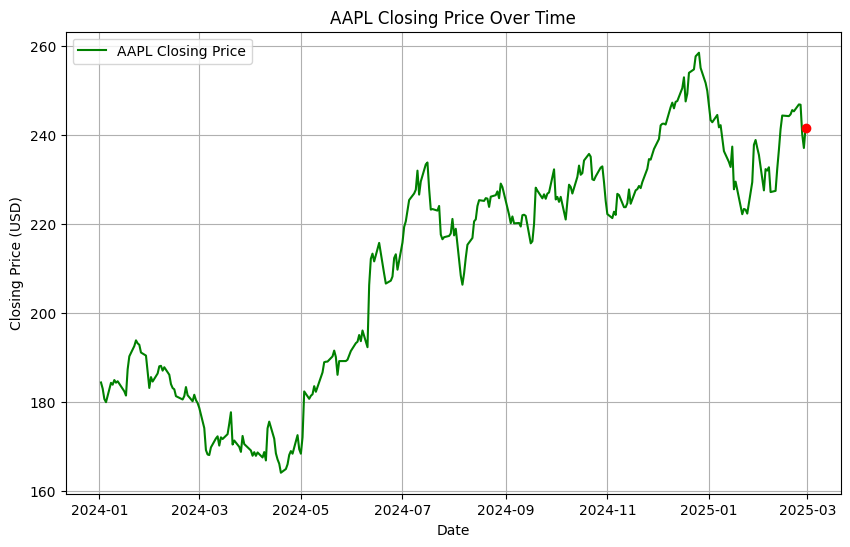

Last closing price for AAPL: Ticker
AAPL    241.52327
Name: 2025-02-28 00:00:00, dtype: float64


In [13]:
plot_closing_price(data_frame , stockn)

In [14]:
#now for two technical 
def calc_macd( data_frame , short_window =12 , long_window = 26 , signal_window=9):
    data_frame['EMA_short'] = data_frame['Close'].ewm(span = short_window , adjust = False).mean()
    data_frame['EMA_Long'] = data_frame['Close'].ewm(span = long_window , adjust = False).mean()

    data_frame['MACD'] = data_frame['EMA_short'] - data_frame['EMA_Long']

    data_frame['Sigma_line'] = data_frame['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data_frame
    

In [15]:
# calculating another tachnical indicator RSI

def calc_rsi(data_frame, period=14):
    delta = data_frame['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    data_frame['RSI'] = 100 - (100 / (1 + rs))
    return data_frame


In [16]:
# Plotting MACD
def plot_macd(data_frame, stockn):
    # Ensure index is datetime (important for financial time series plots)
    if not pd.api.types.is_datetime64_any_dtype(data_frame.index):
        data_frame.index = pd.to_datetime(data_frame.index)

    plt.figure(figsize=(12, 6))
    plt.plot(data_frame.index, data_frame['MACD'], label='MACD', color='blue')
    plt.plot(data_frame.index, data_frame['Sigma_line'], label='Signal Line', color='red')
    plt.title(f'{stockn} MACD')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
# Plotting RSI

def plot_rsi(data_frame, stockn):
    plt.figure(figsize=(12, 6))
    plt.plot(data_frame.index, data_frame['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f'{stockn} RSI')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
calc_macd(data_frame).head()



Price,Close,High,Low,Open,Volume,EMA_short,EMA_Long,MACD,Sigma_line
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2024-01-02,184.290421,187.070068,182.553143,185.789438,82488700,184.290421,184.290421,0.000000,0.000000
2024-01-03,182.910507,184.528662,182.096461,182.880727,58414500,184.078126,184.188205,-0.110079,-0.022016
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600,183.541113,183.921489,-0.380376,-0.093688
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300,182.975225,183.620848,-0.645624,-0.204075
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500,183.165344,183.664563,-0.499219,-0.263104


In [19]:
calc_rsi(data_frame).head()


Price,Close,High,Low,Open,Volume,EMA_short,EMA_Long,MACD,Sigma_line,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,
2024-01-02,184.290421,187.070068,182.553143,185.789438,82488700,184.290421,184.290421,0.000000,0.000000,NaN
2024-01-03,182.910507,184.528662,182.096461,182.880727,58414500,184.078126,184.188205,-0.110079,-0.022016,NaN
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600,183.541113,183.921489,-0.380376,-0.093688,NaN
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300,182.975225,183.620848,-0.645624,-0.204075,NaN
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500,183.165344,183.664563,-0.499219,-0.263104,NaN


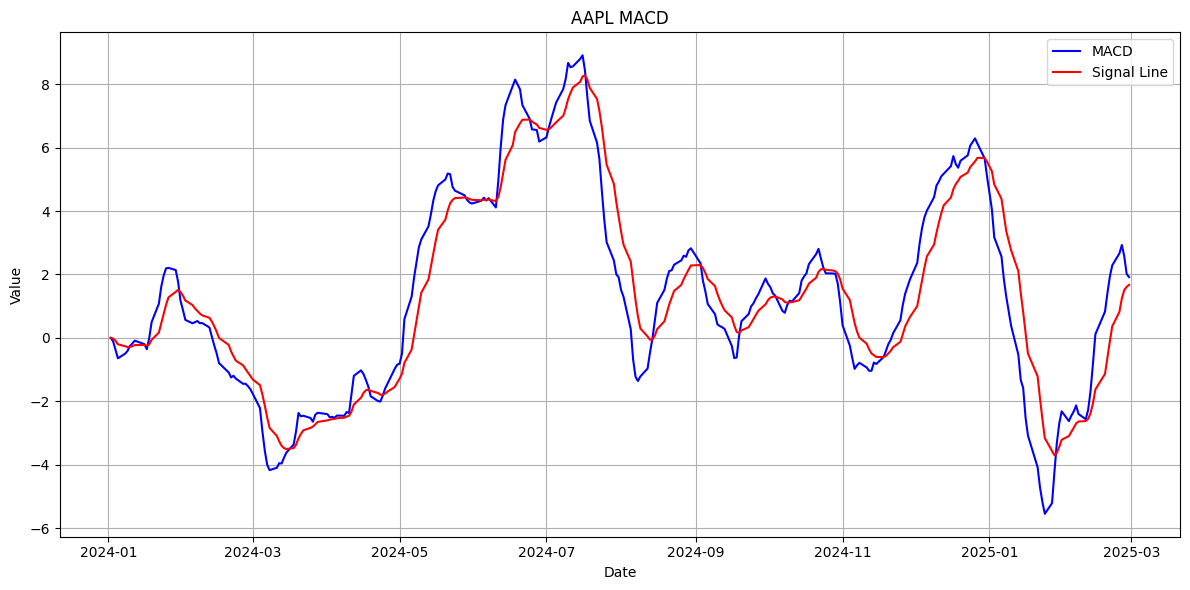

In [20]:
plot_macd(data_frame , stockn)

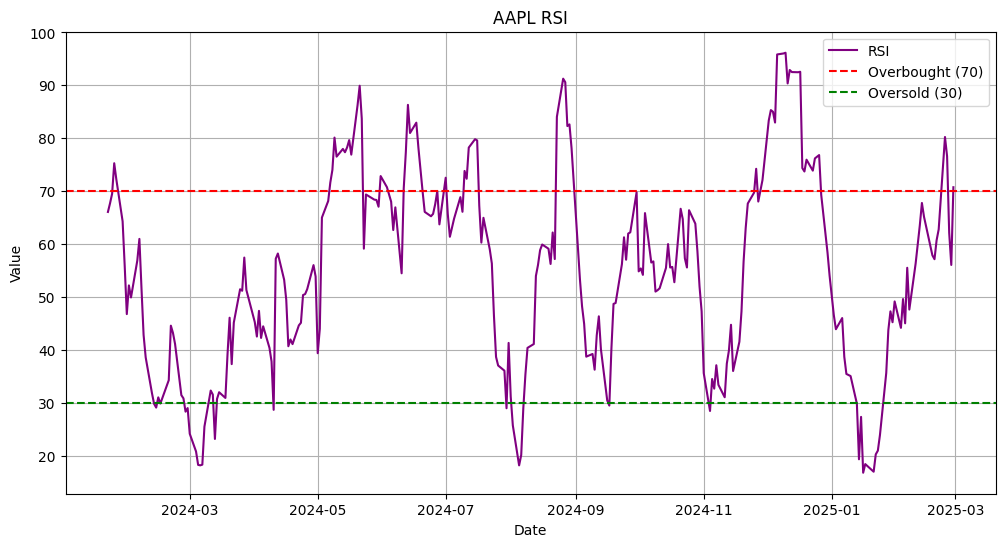

In [21]:
plot_rsi(data_frame,stockn)

In [22]:
# Nomralizing data
%pip install scikit-learn --quiet
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df, columns):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[columns] = scaler.fit_transform(df[columns])
    return df

columns_to_normalize = ['Close', 'Volume', 'EMA_short', 'EMA_Long', 'MACD', 'Sigma_line']



Note: you may need to restart the kernel to use updated packages.


In [23]:
df_normalized = normalize_data(data_frame , columns_to_normalize)

In [24]:
df_normalized.head()

Price,Close,High,Low,Open,Volume,EMA_short,EMA_Long,MACD,Sigma_line,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,
2024-01-02,0.214870,187.070068,182.553143,185.789438,0.200558,0.198307,0.193944,0.383752,0.309039,NaN
2024-01-03,0.200250,184.528662,182.096461,182.880727,0.119074,0.195784,0.192617,0.376142,0.307202,NaN
2024-01-04,0.175639,181.758954,179.565029,180.825785,0.165001,0.189403,0.189152,0.357455,0.301223,NaN
2024-01-05,0.167961,181.431354,178.860187,180.666963,0.132236,0.182678,0.185247,0.339118,0.292013,NaN
2024-01-08,0.214028,184.250716,180.180517,180.766224,0.121545,0.184937,0.185815,0.349239,0.287088,NaN


In [25]:
# Creating sequence with sliding window of past 60 days

def create_sequences(data_frame, feature_columns, target_column, time_steps=60):
    
    features = []
    targets = []
    for i in range(len(data_frame) - time_steps):

        feature_window = data_frame[feature_columns].iloc[i:i + time_steps].values
        
        target_value = data_frame[target_column].iloc[i + time_steps]
        features.append(feature_window)
        targets.append(target_value)
    return np.array(features), np.array(targets)

In [29]:
feature_columns = ['Close', 'Volume', 'EMA_short', 'EMA_Long', 'MACD', 'Sigma_line']
target_column = 'Close'

X, y = create_sequences(df_normalized, feature_columns, target_column)

In [31]:
def create_lstm_model(input_shape, dropout_rate=0.2):
    model = Sequential()
    
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [32]:
# train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create and compile the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  
model = create_lstm_model(input_shape)

model.summary()

C:\Users\ronak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,265 (200.25 KB)

 Trainable params: 51,265 (200.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Training the model

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.3253 - mae: 0.5082 - val_loss: 0.2787 - val_mae: 0.5180
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0966 - mae: 0.2608 - val_loss: 0.2888 - val_mae: 0.4898
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0530 - mae: 0.1885 - val_loss: 0.0330 - val_mae: 0.1554
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0262 - mae: 0.1332 - val_loss: 0.0272 - val_mae: 0.1412
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0139 - mae: 0.0938 - val_loss: 0.0343 - val_mae: 0.1453
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0200 - mae: 0.1137 - val_loss: 0.0177 - val_mae: 0.1079
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0098 - mae: 0.0832 - val_loss: 0.0153 - val_mae: 0.1082
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0145 - mae: 0.0975 - val_loss: 0.0294 - val_mae: 0.1352
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0109 - mae: 0.0857 -

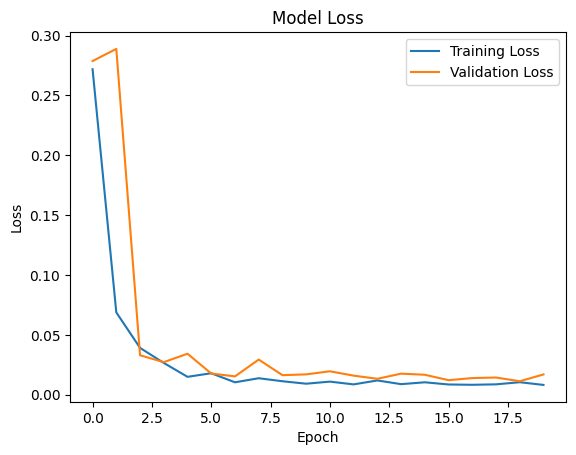

In [34]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



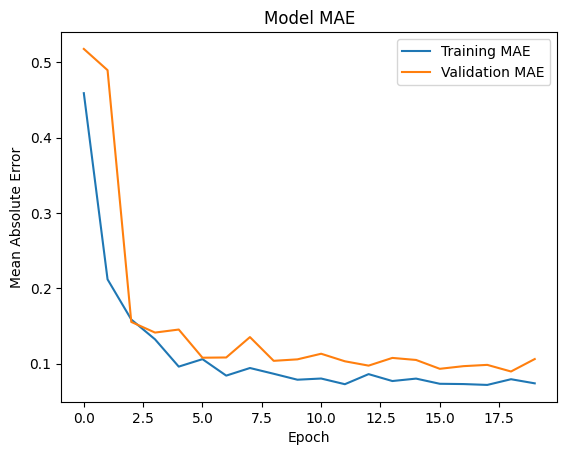

In [35]:
# Plot training & validation MAE (Mean Absolute Error)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [37]:
def predict_next_units(model, data_frame, feature_columns, time_steps, n_predictions):
    predictions = []

    # Start with the last sequence of data
    last_sequence = data_frame[feature_columns].iloc[-time_steps:].values

    for _ in range(n_predictions):
        # Reshape the last sequence to match the model's input shape
        input_data = np.expand_dims(last_sequence, axis=0)

        # Predict the next value (assuming the target is a single value like 'Close')
        predicted_value = model.predict(input_data, verbose=0)[0][0]

        # Append the prediction
        predictions.append(predicted_value)

        # Create a new sequence by adding the predicted value and removing the oldest
        new_row = np.copy(last_sequence[-1])  # Copy the last row to use as a base
        new_row[0] = predicted_value  # Update the target column (e.g., 'Close') with the prediction

        last_sequence = np.append(last_sequence[1:], [new_row], axis=0)

    return predictions

In [38]:
# Parameters
n_predictions = 15
time_steps = X_train.shape[1]  # The sequence length used in training
feature_columns = ['Close', 'Volume', 'EMA_short', 'EMA_Long', 'MACD', 'Sigma_line']  # Adjust to match your data

# Generate predictions
predicted_values = predict_next_units(model, df_normalized, feature_columns, time_steps, n_predictions)

# Denormalize predictions (if normalization was applied)
scaler = MinMaxScaler(feature_range=(0, 1))  # Replace with your actual scaler
scaler.fit(data_frame[['Close']])  # Fit scaler on the original 'Close' column

predicted_values_denormalized = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Display predictions
print("Next 15 predicted values (normalized):", predicted_values)
print("Next 15 predicted values (denormalized):", predicted_values_denormalized)

Next 15 predicted values (normalized): [np.float32(0.8674578), np.float32(0.8746431), np.float32(0.8812731), np.float32(0.8873328), np.float32(0.89284235), np.float32(0.89783955), np.float32(0.9023702), np.float32(0.90648216), np.float32(0.910221), np.float32(0.91363317), np.float32(0.9167584), np.float32(0.91963035), np.float32(0.9222766), np.float32(0.9247217), np.float32(0.92698634)]
Next 15 predicted values (denormalized): [[0.8674578 ]
 [0.8746431 ]
 [0.8812731 ]
 [0.8873328 ]
 [0.89284235]
 [0.89783955]
 [0.9023702 ]
 [0.90648216]
 [0.910221  ]
 [0.91363317]
 [0.9167584 ]
 [0.91963035]
 [0.9222766 ]
 [0.9247217 ]
 [0.92698634]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


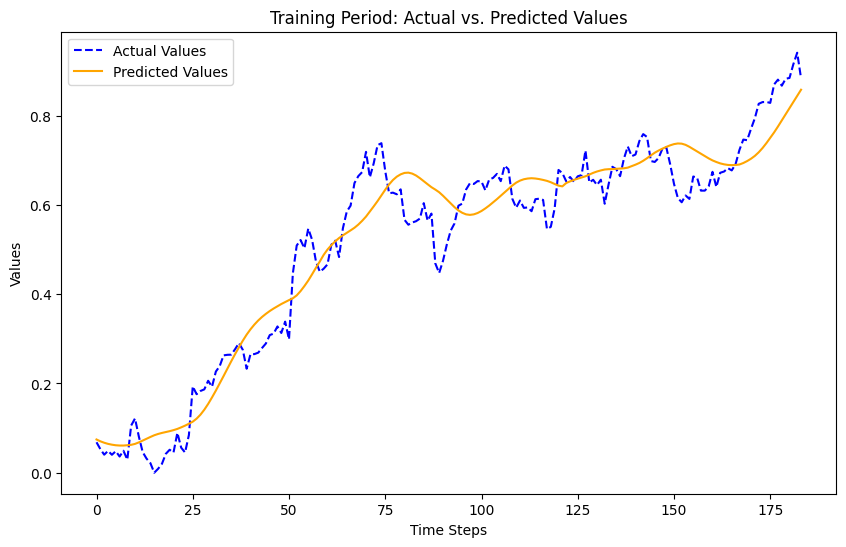

In [39]:
# Actual vs predicted graph

y_train_pred = model.predict(X_train)

plt.figure(figsize=(10, 6))
plt.plot(y_train, label="Actual Values", color="blue", linestyle="--")
plt.plot(y_train_pred, label="Predicted Values", color="orange")
plt.title("Training Period: Actual vs. Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


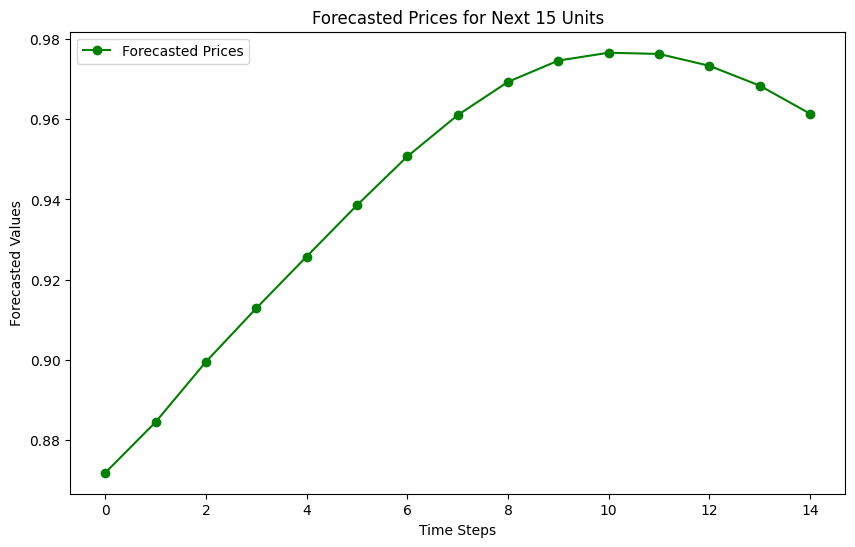

In [40]:
# forecasted graph

forecasted_prices = model.predict(X_test[:15])  # Replace [:15] if your test set is longer

plt.figure(figsize=(10, 6))
plt.plot(range(15), forecasted_prices, marker="o", color="green", label="Forecasted Prices")
plt.title("Forecasted Prices for Next 15 Units")
plt.xlabel("Time Steps")
plt.ylabel("Forecasted Values")
plt.legend()
plt.show()

In [41]:
# calculating R^2 using formula 

ss_res = np.sum((y_train - y_train_pred)**2)  # Residual sum of squares
ss_tot = np.sum((y_train - np.mean(y_train))**2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)
print(f"R² Score for Training Period: {r2:.4f}")


R² Score for Training Period: 0.9287
